# Stage 1: Synthetic Dataset (Framework Validation)
This stage uses a controlled synthetic dataset with intentionally introduced bias
to validate bias detection, fairness metrics, mitigation, and explainability.


In [1]:
!pip install shap fairlearn scikit-learn pandas numpy matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import shap
import matplotlib.pyplot as plt

from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    MetricFrame
)

In [3]:
np.random.seed(42)
n = 1000

# Sensitive attribute
gender = np.random.choice(["Male", "Female"], size=n, p=[0.6, 0.4])

# Features
feature_1 = np.random.normal(0, 1, n)
feature_2 = np.random.normal(0, 1, n)

# Introduce proxy bias
feature_2 = np.where(gender == "Male", feature_2 + 0.8, feature_2)

# Label generation with intentional bias
logits = (
    0.7 * feature_1 +
    0.5 * feature_2 +
    np.where(gender == "Male", 0.6, -0.3)  # explicit bias
)

prob = 1 / (1 + np.exp(-logits))
label = (prob > 0.5).astype(int)

df = pd.DataFrame({
    "feature_1": feature_1,
    "feature_2": feature_2,
    "gender": gender,
    "label": label
})

df.head()

,feature_1,feature_2,gender,label
0,0.177701,-0.606317,Male,1
1,-1.335344,-0.083106,Female,0
2,0.380198,-1.504720,Female,0
3,0.610586,1.560056,Male,1
4,0.559790,0.882440,Male,1


In [4]:
# Representation bias
df["gender"].value_counts(normalize=True)

,proportion
gender,
Male,0.613
Female,0.387


In [5]:
# Outcome disparity
pd.crosstab(df["gender"], df["label"], normalize="index")

label,0,1
gender,,
Female,0.596899,0.403101
Male,0.097879,0.902121


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[["feature_1", "feature_2"]]
y = df["label"]
sensitive = df["gender"]

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.87

In [8]:
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference
)

dp = demographic_parity_difference(
    y_test, y_pred, sensitive_features=s_test
)

eo = equalized_odds_difference(
    y_test, y_pred, sensitive_features=s_test
)

dp, eo


(np.float64(0.16926291793313075), 0.3387096774193548)

In [9]:
from fairlearn.metrics import MetricFrame

mf = MetricFrame(
    metrics={"accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=s_test
)

mf.by_group

,accuracy
gender,
Female,0.812500
Male,0.904255


In [10]:
import shap

explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

/tmp/ipython-input-319187617.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=["feature_1", "feature_2"])


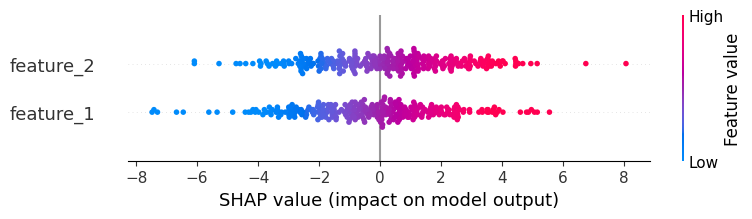

In [11]:
shap.summary_plot(shap_values, X_test, feature_names=["feature_1", "feature_2"])

/tmp/ipython-input-946996809.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


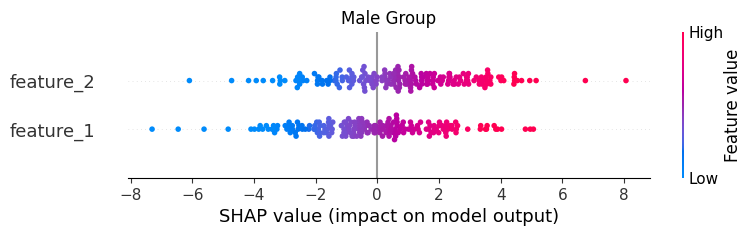

/tmp/ipython-input-946996809.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


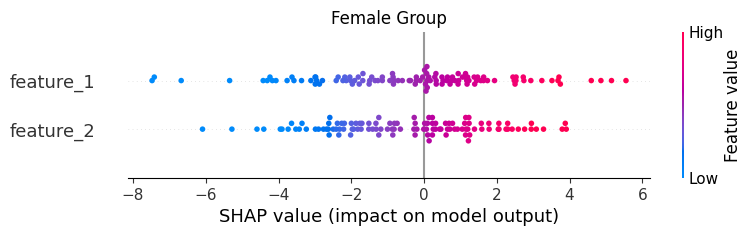

In [12]:
male_idx = s_test == "Male"
female_idx = s_test == "Female"

shap.summary_plot(
    shap_values[male_idx],
    X_test[male_idx],
    feature_names=["feature_1", "feature_2"],
    show=False
)
plt.title("Male Group")
plt.show()

shap.summary_plot(
    shap_values[female_idx],
    X_test[female_idx],
    feature_names=["feature_1", "feature_2"],
    show=False
)
plt.title("Female Group")
plt.show()

In [18]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression

In [19]:
constraint = DemographicParity()

mitigator = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=constraint
)

mitigator.fit(
    X_train,
    y_train,
    sensitive_features=s_train
)

y_pred_fair = mitigator.predict(X_test)


In [20]:
from sklearn.metrics import accuracy_score

accuracy_before = accuracy_score(y_test, y_pred)
accuracy_after = accuracy_score(y_test, y_pred_fair)

accuracy_before, accuracy_after

(0.87, 0.7566666666666667)

In [21]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

dp_after = demographic_parity_difference(
    y_test, y_pred_fair, sensitive_features=s_test
)

eo_after = equalized_odds_difference(
    y_test, y_pred_fair, sensitive_features=s_test
)

dp_after, eo_after

(np.float64(0.03305471124620063), 0.3531409168081494)

In [22]:
from fairlearn.metrics import MetricFrame

mf_after = MetricFrame(
    metrics={"accuracy": accuracy_score},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=s_test
)

mf_after.by_group

,accuracy
gender,
Female,0.535714
Male,0.888298


In [25]:
import numpy as np

idx = np.argmax(mitigator.weights_)
representative_model = mitigator.predictors_[idx]


/tmp/ipython-input-3537546551.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


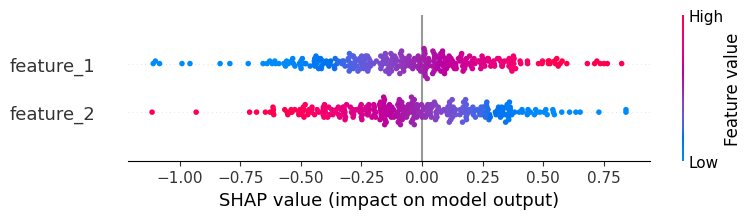

In [26]:
import shap

explainer_fair = shap.LinearExplainer(
    representative_model,
    X_train
)

shap_values_fair = explainer_fair.shap_values(X_test)

shap.summary_plot(
    shap_values_fair,
    X_test,
    feature_names=["feature_1", "feature_2"]
)

/tmp/ipython-input-954966235.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


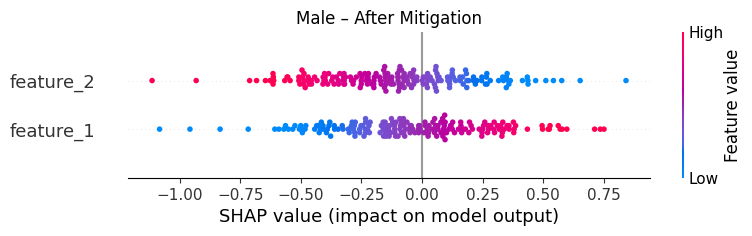

/tmp/ipython-input-954966235.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


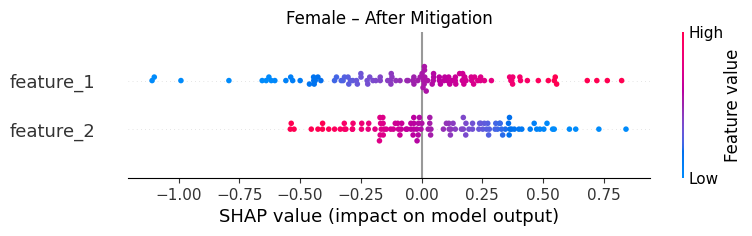

In [27]:
male_idx = s_test == "Male"
female_idx = s_test == "Female"

shap.summary_plot(
    shap_values_fair[male_idx],
    X_test[male_idx],
    feature_names=["feature_1", "feature_2"],
    show=False
)
plt.title("Male – After Mitigation")
plt.show()

shap.summary_plot(
    shap_values_fair[female_idx],
    X_test[female_idx],
    feature_names=["feature_1", "feature_2"],
    show=False
)
plt.title("Female – After Mitigation")
plt.show()

# Stage 2: Evaluation on Real-World Dataset (UCI Adult)

This stage evaluates the same bias and fairness pipeline on a real-world benchmark
dataset to demonstrate applicability beyond synthetic data.

In [28]:
from sklearn.datasets import fetch_openml
import pandas as pd

adult = fetch_openml("adult", version=2, as_frame=True)
df_real = adult.frame

df_real.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [29]:
# Remove missing values
df_real = df_real.replace("?", pd.NA).dropna()

# Binary label
df_real["income"] = (df_real["class"] == ">50K").astype(int)

df_real.shape

(45222, 16)

In [30]:
sensitive_real = df_real["sex"]
sensitive_real.value_counts()

,count
sex,
Male,30527
Female,14695


In [31]:
X_real = df_real.drop(columns=["class", "income"])
y_real = df_real["income"]

# One-hot encode categorical features
X_real = pd.get_dummies(X_real, drop_first=True)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Xr_train, Xr_test, yr_train, yr_test, sr_train, sr_test = train_test_split(
    X_real, y_real, sensitive_real,
    test_size=0.3,
    random_state=42,
    stratify=y_real
)

scaler = StandardScaler()
Xr_train = scaler.fit_transform(Xr_train)
Xr_test = scaler.transform(Xr_test)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

baseline_real = LogisticRegression(max_iter=1000)
baseline_real.fit(Xr_train, yr_train)

yr_pred = baseline_real.predict(Xr_test)

accuracy_score(yr_test, yr_pred)

0.8439596078720425

In [34]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

dp_real_before = demographic_parity_difference(
    yr_test, yr_pred, sensitive_features=sr_test
)

eo_real_before = equalized_odds_difference(
    yr_test, yr_pred, sensitive_features=sr_test
)

dp_real_before, eo_real_before

(np.float64(0.18010178737101107), 0.1117307028893203)

In [35]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

mitigator_real = ExponentiatedGradient(
    estimator=LogisticRegression(solver="liblinear"),
    constraints=DemographicParity()
)

mitigator_real.fit(
    Xr_train,
    yr_train,
    sensitive_features=sr_train
)

yr_pred_fair = mitigator_real.predict(Xr_test)

In [36]:
dp_real_after = demographic_parity_difference(
    yr_test, yr_pred_fair, sensitive_features=sr_test
)

eo_real_after = equalized_odds_difference(
    yr_test, yr_pred_fair, sensitive_features=sr_test
)

dp_real_after, eo_real_after

(np.float64(0.005551941809238015), 0.33666609504376255)

In [37]:
dp_after < dp_before

np.True_

In [38]:
acc_real_before = accuracy_score(yr_test, yr_pred)
acc_real_after = accuracy_score(yr_test, yr_pred_fair)

acc_real_before, acc_real_after

(0.8439596078720425, 0.8283334561804379)

/tmp/ipython-input-4131708546.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_real, Xr_test)


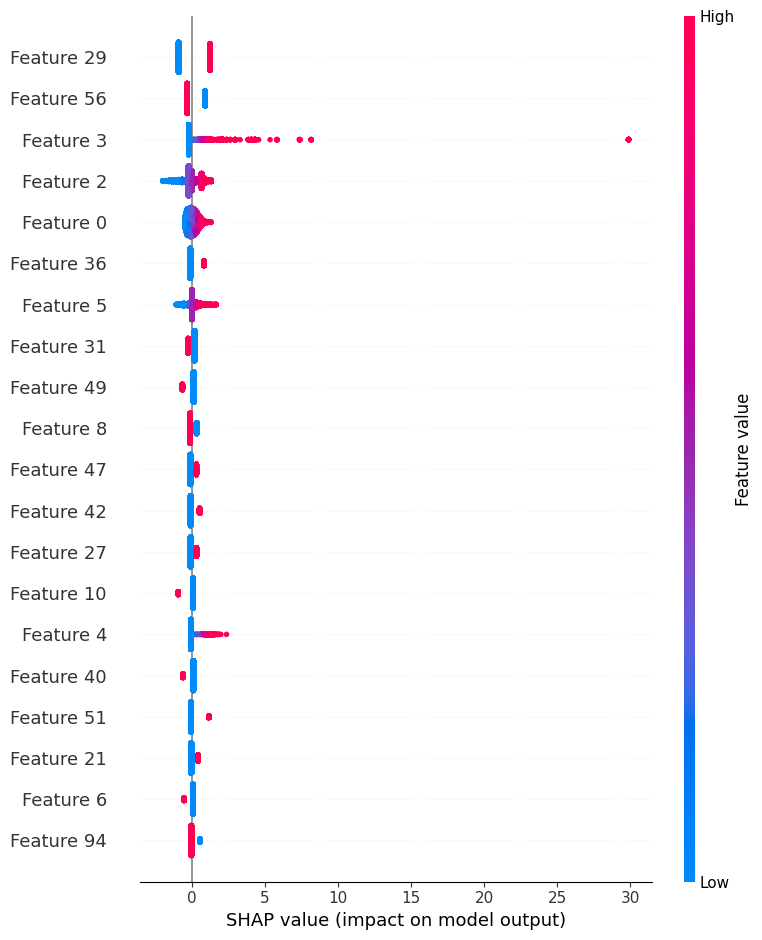

In [39]:
import numpy as np
import shap

idx = np.argmax(mitigator_real.weights_)
rep_model_real = mitigator_real.predictors_[idx]

explainer_real = shap.LinearExplainer(rep_model_real, Xr_train)
shap_values_real = explainer_real.shap_values(Xr_test)

shap.summary_plot(shap_values_real, Xr_test)

In [40]:
comparison_real = pd.DataFrame({
    "Metric": ["Accuracy", "Demographic Parity", "Equalized Odds"],
    "Before Mitigation": [acc_real_before, dp_real_before, eo_real_before],
    "After Mitigation": [acc_real_after, dp_real_after, eo_real_after]
})

comparison_real

,Metric,Before Mitigation,After Mitigation
0,Accuracy,0.843960,0.828333
1,Demographic Parity,0.180102,0.005552
2,Equalized Odds,0.111731,0.336666
